In [29]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import sys
import msgpack as mp
import msgpack_numpy as mpn
import datetime
import toml
import polars as pl
from cv2 import aruco
from datetime import datetime
from scipy.spatial.transform import Rotation as R
from tqdm import tqdm

sys.path.append(os.path.join(os.getcwd(), ".."))
from support.pd_support import *
from datetime import datetime
from support.pd_support import *
from support.ar_calculations import *
from scipy import stats
from scipy.interpolate import interp1d

## Calibration file import

In [30]:
settings = toml.load("calibration.toml")
_webcam_cam_mat = np.array(settings["calibration"]["camera_matrix"]).reshape((3, 3))
_webcam_dist = np.array(settings["calibration"]["dist_coeffs"]).reshape((1, 5))

In [31]:
_name = "five_rpi_rotation_t0"

_base_dir = os.path.join(
    os.path.abspath(os.path.join(os.getcwd(), "..")),
    "recorded_data",
    "five_marker_validation",
)
_data_pth = os.path.join(_base_dir, _name)
_video_binary_file = os.path.join(_data_pth, "webcam_color.msgpack")
_video_timestamp_file = os.path.join(_data_pth, "webcam_timestamp.msgpack")

In [32]:
ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_ARUCO_MIP_36H12)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = 0.05
markerSeperation = 0.01

board = aruco.GridBoard(
    size=[1, 1],
    markerLength=markerLength,
    markerSeparation=markerSeperation,
    dictionary=ARUCO_DICT,
)

In [33]:
ts_pth = os.path.join(_video_timestamp_file)
with open(ts_pth, "rb") as ts_file:
    ts_unpacker = mp.Unpacker(ts_file, object_hook=mpn.decode)
    ts = list(ts_unpacker)

_time = np.array(ts)[:, 1]
_time = [datetime.strptime(_t, "%Y-%m-%d %H:%M:%S.%f") for _t in _time]
_sync = np.array(ts)[:, 0].astype(bool)

In [34]:
def estimatePoseSingleMarkers(corners, marker_size, mtx, distortion):
    marker_points = np.array(
        [
            [-marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, -marker_size / 2, 0],
            [-marker_size / 2, -marker_size / 2, 0],
        ],
        dtype=np.float32,
    )
    trash = []
    rvecs = []
    tvecs = []
    for c in corners:
        nada, R, t = cv2.solvePnP(
            marker_points, c, mtx, distortion, True, flags=cv2.SOLVEPNP_ITERATIVE
        )

        if not (R is None or t is None):
            R = np.array(R).reshape(1, 3).tolist()
            t = np.array(t).reshape(1, 3).tolist()

        rvecs.append(R)
        tvecs.append(t)
    return rvecs, tvecs

In [35]:
_video = open(_video_binary_file, "rb")
_video_file = mp.Unpacker(_video, object_hook=mpn.decode)
corners_data = list(_video_file)
shape = corners_data[0]

In [36]:
_video = open(_video_binary_file, "rb")
_video_file = mp.Unpacker(_video, object_hook=mpn.decode)
corners_data = list(_video_file)
shape = corners_data[0]

data = {"frame_id": [], "marker_ids": [], "corners": [], "tvec": [], "rvec": []}
counter = 0

for _frame in tqdm(corners_data[1:]):
    corners, ids = _frame
    rvec, tvec = estimatePoseSingleMarkers(
        corners=corners, marker_size=0.05, mtx=_webcam_cam_mat, distortion=_webcam_dist
    )

    if ids is None:
        data["frame_id"].append(counter)
        data["marker_ids"].append(None)
        data["corners"].append(None)
        data["tvec"].append(None)
        data["rvec"].append(None)

    if ids is not None:
        data["frame_id"].append(counter)
        data["marker_ids"].append(ids)
        data["corners"].append(corners)
        data["tvec"].append(tvec)
        data["rvec"].append(rvec)
    counter += 1

100%|██████████| 2518/2518 [00:00<00:00, 4227.41it/s]


In [37]:
default_ids = [12, 14, 20, 88, 89]
coordinate = {
    str(id): {"x": [], "y": [], "z": [], "rx": [], "ry": [], "rz": []}
    for id in default_ids
}

for i, frame_id in enumerate(data["frame_id"]):
    if data["marker_ids"][i] is not None:
        existing_ids = set(data["marker_ids"][i].reshape(-1))
        missing_ids = set(default_ids) - existing_ids

        for _m, tvec, rvec in zip(
            data["marker_ids"][i], data["tvec"][i], data["rvec"][i]
        ):
            if _m in default_ids:
                coord = coordinate[str(_m[0])]
                coord["x"].append(tvec[0][0])
                coord["y"].append(tvec[0][1])
                coord["z"].append(tvec[0][2])
                coord["rx"].append(rvec[0][0])
                coord["ry"].append(rvec[0][1])
                coord["rz"].append(rvec[0][2])

        for _m in missing_ids:
            coord = coordinate[str(_m)]
            coord["x"].append(np.nan)
            coord["y"].append(np.nan)
            coord["z"].append(np.nan)
            coord["rx"].append(np.nan)
            coord["ry"].append(np.nan)
            coord["rz"].append(np.nan)
    else:
        for _m in default_ids:
            coord = coordinate[str(_m)]
            coord["x"].append(np.nan)
            coord["y"].append(np.nan)
            coord["z"].append(np.nan)
            coord["rx"].append(np.nan)
            coord["ry"].append(np.nan)
            coord["rz"].append(np.nan)

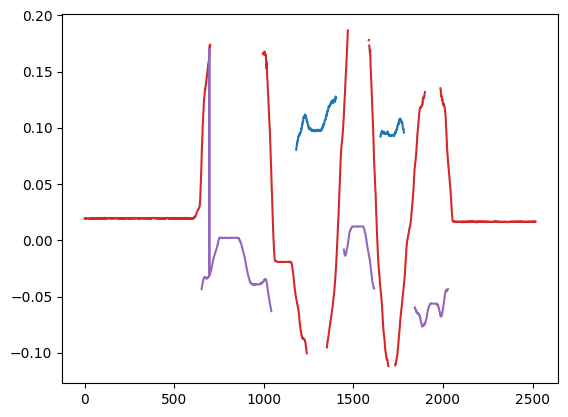

In [38]:
plt.plot(coordinate["12"]["x"])
plt.plot(coordinate["14"]["x"])
plt.plot(coordinate["20"]["x"])
plt.plot(coordinate["88"]["x"])
plt.plot(coordinate["89"]["x"])

## Transforming the coordinates to center

In [39]:
# Define offsets
offsets = {
    12: np.array([-0.09, 0.031, -0.069]),
    14: np.array([0.00, 0.1025, -0.069]),
    20: np.array([0.00, 0.01, -0.069]),
    88: np.array([0.00, 0.031, -0.1075]),
    89: np.array([0.1, 0.031, -0.069]),
}

offsets = {
    12: np.array([-0.09, 0.0, -0.069]),
    14: np.array([0.00, 0.1025, -0.069]),
    20: np.array([0.00, 0.01, -0.069]),
    88: np.array([0.00, 0.0, -0.1075]),
    89: np.array([0.1, 0.0, -0.055]),
}


# Function to compute transformed coordinates
def compute_transformed_coordinates(coordinate, id_offset):
    rotation_matrix = R.from_rotvec(
        np.array([coordinate["rx"], coordinate["ry"], coordinate["rz"]]).T
    ).as_matrix()
    translation_vector = np.array([coordinate["x"], coordinate["y"], coordinate["z"]])
    transformed = np.array(
        [
            (_r @ id_offset.reshape(3, 1) + _t.reshape(3, 1)).T[0]
            for _r, _t in zip(rotation_matrix, translation_vector.T)
        ]
    )
    return rotation_matrix, translation_vector, transformed


# Compute transformations
results = {}
for key in offsets.keys():
    results[key] = compute_transformed_coordinates(coordinate[str(key)], offsets[key])

# Transform to global coordinates
_r_88_inv = results[88][0][5].T
_tvec_88_0 = results[88][2][0]

world_coordinates = {}
for key in offsets.keys():
    world_coordinates[key] = _r_88_inv @ (results[key][2] - _tvec_88_0).T

_gt_12, _gt_14, _gt_20, _gt_88, _gt_89 = [
    world_coordinates[key] for key in [12, 14, 20, 88, 89]
]
_mean_val = np.nanmean([_gt_12, _gt_14, _gt_20, _gt_88, _gt_89.T[1:].T], axis=0)

C:\Users\Pintu\AppData\Local\Temp\ipykernel_34524\3154510476.py:39: RuntimeWarning: Mean of empty slice
  _mean_val = np.nanmean([_gt_12, _gt_14, _gt_20, _gt_88, _gt_89.T[1:].T], axis=0)


## Reading sync pulse

In [40]:
start_idx = list(_sync).index(1)
end_idx = start_idx + list(_sync[start_idx:]).index(0)
_sync = _sync[start_idx:end_idx]
_time = _time[start_idx:end_idx]
sync_start_time = _time[0]
sync_end_time = _time[-1]

In [41]:
_mean_val = _mean_val.T[start_idx:end_idx]

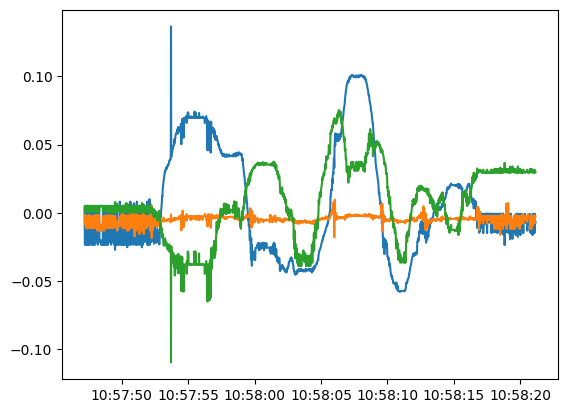

In [42]:
# plt.plot(_tvec_88.T)
# plt.plot(_gt_88[0])
# plt.plot(_gt_12[0])
# plt.plot(_gt_89[0])
plt.plot(_time, _mean_val)

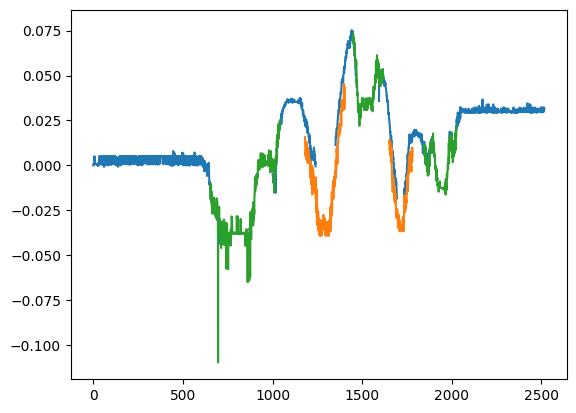

In [43]:
plt.plot(_gt_88[2])
plt.plot(_gt_12[2])
plt.plot(_gt_89[2])

## reading mocap file

In [44]:
_mocap_path = os.path.join(
    os.path.abspath(os.path.join(os.getcwd(), "..")),
    "recorded_data",
    "five_marker_validation",
    "mocap",
    f"{_name}.csv",
)
_mocap_df, st_time = read_rigid_body_csv(_mocap_path)
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")

_mocap_df = pl.from_pandas(_mocap_df)

e:\CMC\pyprojects\DeepVision\wearable\..\support\pd_support.py:326: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  _rb_df = _rb_df.apply(pd.to_numeric, errors="ignore")


In [45]:
_mocap_quat = R.from_quat(
    _mocap_df[["rb_ang_x", "rb_ang_y", "rb_ang_z", "rb_ang_w"]][0].to_numpy()
)
_mocap_mat = _mocap_quat.as_matrix()[0]

In [46]:
_m = get_rb_marker_name(7)
_m_org = _mocap_df[[_m["x"], _m["y"], _m["z"]]][0].to_numpy().T
_m_tvec = _mocap_df[[_m["x"], _m["y"], _m["z"]]].to_numpy().T
_m_transformed = _mocap_mat.T @ (_m_tvec - _m_org)

In [47]:
_time_offset = sync_start_time - _mocap_df["time"][0]

In [48]:
_mean_val = _mean_val.T

In [49]:
_mocap_df = _mocap_df.with_columns([(pl.col("time") + _time_offset).alias("time")])

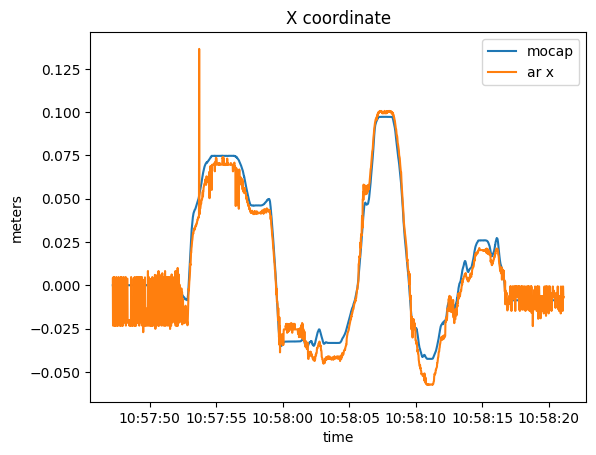

In [50]:
plt.plot(_mocap_df["time"], _m_transformed[0], label="mocap")
plt.plot(_time, _mean_val[0], label="ar x")
plt.xlabel("time")
plt.ylabel("meters")
plt.title("X coordinate")
plt.legend()

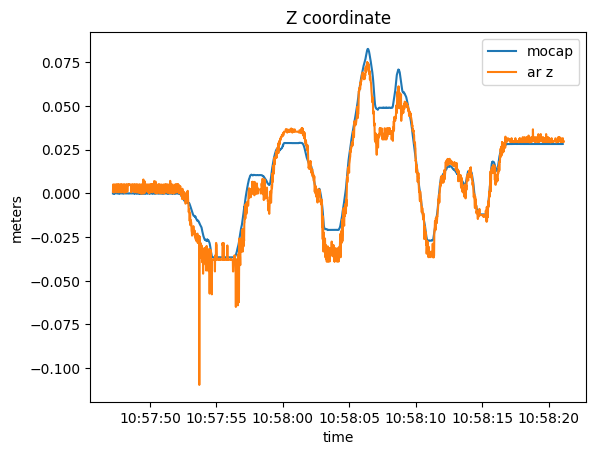

In [51]:
plt.plot(_mocap_df["time"], _m_transformed[2], label="mocap")
plt.plot(_time, _mean_val[2], label="ar z")
plt.xlabel("time")
plt.ylabel("meters")
plt.title("Z coordinate")
plt.legend()

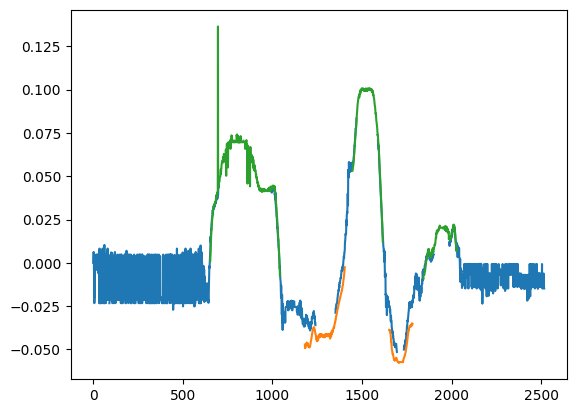

In [52]:
plt.plot(_gt_88[0])
plt.plot(_gt_12[0])
plt.plot(_gt_89[0])

## Error

In [53]:
ar_df = pl.from_dict(
    {"time": _time, "x": _mean_val[0], "y": _mean_val[1], "z": _mean_val[2]}
)

In [54]:
ar_df["time"].dt.epoch()

time
i64
1721300267221831
1721300267236926
1721300267254017
1721300267272567
1721300267288163
…
1721300301071331
1721300301087352
1721300301104513


In [55]:
f1 = interp1d(ar_df["time"].dt.epoch(), ar_df["x"], fill_value="extrapolate")
f2 = interp1d(ar_df["time"].dt.epoch(), ar_df["y"], fill_value="extrapolate")
f3 = interp1d(ar_df["time"].dt.epoch(), ar_df["z"], fill_value="extrapolate")

_ar_x = f1(_mocap_df["time"].dt.epoch())
_ar_y = f2(_mocap_df["time"].dt.epoch())
_ar_z = f3(_mocap_df["time"].dt.epoch())

_err_x = _m_transformed[0] - _ar_x
_err_y = _m_transformed[1] - _ar_y
_err_z = _m_transformed[2] - _ar_z


zscore_x = np.abs(stats.zscore(_err_x, nan_policy="omit"))
zscore_y = np.abs(stats.zscore(_err_y, nan_policy="omit"))
zscore_z = np.abs(stats.zscore(_err_z, nan_policy="omit"))
_zerr_x = _err_x[np.where(zscore_x < 3)]
_zerr_y = _err_y[np.where(zscore_y < 3)]
_zerr_z = _err_z[np.where(zscore_z < 3)]

In [56]:
print("mean", np.nanmean(_zerr_x), np.nanmean(_zerr_y), np.nanmean(_zerr_z))
print("median", np.nanmedian(_zerr_x), np.nanmedian(_zerr_y), np.nanmedian(_zerr_z))
print("max", np.nanmax(_zerr_x), np.nanmax(_zerr_y), np.nanmax(_zerr_z))

mean 0.004434596847929201 0.004284331029207906 0.002520137252939165
median 0.004883357594285126 0.003957497640261468 0.001073406818756572
max 0.025168865527513972 0.013539311847421421 0.022055120657331014
